In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

from keras import backend as K
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Rescaling,InputLayer, regularization
from keras.layers import Conv2D, MaxPool2D, Input
import matplotlib.pylab as plt
#from tensorflow.python.client import device_lib
from keras.callbacks import CSVLogger
from keras.utils import plot_model
from keras.regularizers import l2 # ridge reg
from keras.regularizers import l1 # lasso reg
from keras.optimizers import Adam, SGD, RMSprop, Adamax
from keras import mixed_precision
import pandas as pd
import numpy as np
import os
import sys
#from layers import BilinearInterpolation
from keras.layers import RandomFlip, RandomRotation, RandomZoom
import random as python_random
from layers import BilinearInterpolation
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

In [8]:
class BilinearInterpolation(tf.keras.layers.Layer):
    '''
    Used to construct Spatial Transformer Networks with Keras.

    See Spatial Transformer Networks, Max Jaderberg, et al.

    Based on https://github.com/oarriaga/STN.keras, with only very minor
    changes.

    '''

    def __init__(self, output_size: tuple, **kwargs):
        assert len(output_size) == 2
        for e in output_size:
            assert isinstance(e, int) and e > 0

        super(BilinearInterpolation, self).__init__(**kwargs)
        self.output_size = output_size

    def get_config(self):
        return {'output_size': self.output_size}

    def compute_output_shape(self, input_shape):
        height, width = self.output_size
        num_channels = input_shape[0][-1]

        return None, height, width, num_channels

    def call(self, inputs, **kwargs):
        X, transformation = inputs
        output = self._transform(X, transformation, self.output_size)

        return output

    def _interpolate(self, image, sampled_grids, output_size):
        batch_size = K.shape(image)[0]
        height = K.shape(image)[1]
        width = K.shape(image)[2]
        num_channels = K.shape(image)[3]

        x = K.cast(K.flatten(sampled_grids[:, 0:1, :]), dtype='float32')
        y = K.cast(K.flatten(sampled_grids[:, 1:2, :]), dtype='float32')

        x = .5 * (x + 1.0) * K.cast(width, dtype='float32')
        y = .5 * (y + 1.0) * K.cast(height, dtype='float32')

        x0 = K.cast(x, 'int32')
        x1 = x0 + 1
        y0 = K.cast(y, 'int32')
        y1 = y0 + 1

        max_x = int(K.int_shape(image)[2] - 1)
        max_y = int(K.int_shape(image)[1] - 1)

        x0 = K.clip(x0, 0, max_x)
        x1 = K.clip(x1, 0, max_x)
        y0 = K.clip(y0, 0, max_y)
        y1 = K.clip(y1, 0, max_y)

        pixels_batch = K.arange(0, batch_size) * (height * width)
        pixels_batch = K.expand_dims(pixels_batch, axis=-1)
        flat_output_size = output_size[0] * output_size[1]
        base = K.repeat_elements(pixels_batch, flat_output_size, axis=1)
        base = K.flatten(base)

        # base_y0 = base + (y0 * width)
        base_y0 = y0 * width
        base_y0 = base + base_y0
        # base_y1 = base + (y1 * width)
        base_y1 = y1 * width
        base_y1 = base_y1 + base

        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = K.reshape(image, shape=(-1, num_channels))
        flat_image = K.cast(flat_image, dtype='float32')
        pixel_values_a = K.gather(flat_image, indices_a)
        pixel_values_b = K.gather(flat_image, indices_b)
        pixel_values_c = K.gather(flat_image, indices_c)
        pixel_values_d = K.gather(flat_image, indices_d)

        x0 = K.cast(x0, 'float32')
        x1 = K.cast(x1, 'float32')
        y0 = K.cast(y0, 'float32')
        y1 = K.cast(y1, 'float32')

        area_a = K.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = K.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = K.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = K.expand_dims(((x - x0) * (y - y0)), 1)

        values_a = area_a * pixel_values_a
        values_b = area_b * pixel_values_b
        values_c = area_c * pixel_values_c
        values_d = area_d * pixel_values_d

        return values_a + values_b + values_c + values_d

    def _make_regular_grids(self, batch_size, height, width):
        # making a single regular grid
        x_linspace = tf.linspace(-1., 1., width)
        y_linspace = tf.linspace(-1., 1., height)
        x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
        x_coordinates = K.flatten(x_coordinates)
        y_coordinates = K.flatten(y_coordinates)
        ones = K.ones_like(x_coordinates)
        grid = K.concatenate([x_coordinates, y_coordinates, ones], 0)

        # repeating grids for each batch
        grid = K.flatten(grid)
        grids = K.tile(grid, K.stack([batch_size]))

        return K.reshape(grids, (batch_size, 3, height * width))

    def _transform(self, X, affine_transformation, output_size):
        batch_size, num_channels = K.shape(X)[0], K.shape(X)[3]
        transformations = K.reshape(
            affine_transformation,
            shape=(batch_size, 2, 3),
            )
        # transformations = K.cast(affine_transformation[:, 0:2, :], 'float32')
        regular_grids = self._make_regular_grids(batch_size, *output_size)
        sampled_grids = K.batch_dot(transformations, regular_grids)
        interpolated_image = self._interpolate(X, sampled_grids, output_size)
        new_shape = (batch_size, output_size[0], output_size[1], num_channels)
        interpolated_image = K.reshape(interpolated_image, new_shape)

        return interpolated_image


if __name__ == '__main__':
    pass

In [9]:
#Importing the necessary libraries

from tensorflow import keras
import os,datetime

ds1,ds2,ds3 = tfds.load('patch_camelyon', split=['train[:50%]', 'test[:1%]', 'validation[:5%]'],
 data_dir = r'C:\Users\45426\Desktop\Data Science\Applied Machine learning\git\Applied_machinelearning',
 shuffle_files = True,
 download = False)

In [10]:
#Exploring MNIST dataset

(mist_x_train, mist_y_train), (mist_x_test, mist_y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(mist_y_test)
print(mist_y_train)
mist_x_train.shape
mist_y_train.shape

[9 2 1 ... 8 1 5]
[9 0 0 ... 3 0 5]


(60000,)

In [11]:
#A function to help scale the images
def preprocess(sample):
  #image = tf.image.rgb_to_grayscale(image)
  image = sample['image']
  label = sample['label']
  image = tf.cast(image, tf.float32)
  #label =tf.one_hot(label, 2, dtype=tf.float16)
  image /= 255.
  
  return image, label

#Applying the preprocess function we the use of map() method
train_data = ds1.map(preprocess)
valid_data = ds2.map(preprocess)
test_data = ds3.map(preprocess)

In [12]:
#Shuffling the train_data
buffer_size = 1000
train_data = train_data.shuffle(buffer_size)

#Batching and prefetching
batch_size = 512
train_data = train_data.batch(batch_size).prefetch(1)
valid_data = valid_data.batch(batch_size).prefetch(1)
test_data = test_data.batch(batch_size).prefetch(1)

In [13]:
#Separating image and label into different variables
train_ds, train_labels = next(iter(train_data))
val_ds, val_labels = next(iter(valid_data))

In [14]:
tf.keras.backend.clear_session()

In [15]:
# Spatial transformer network

def set_initial_weights(input_nodes: int, set_zoom: float):
    bias = np.zeros((2,3), dtype = 'float32')
    
    bias[0, 0] = set_zoom
    bias[1, 1] = set_zoom

    weights = np.zeros((input_nodes, 6), dtype = 'float32')

    return [weights, bias.flatten()]

def make_location_model(set_zoom):
    #Basic architecture of the CNN model
    location_model = Sequential()
    # location_model.add(Conv2D(6, kernel_size = 10, activation='relu', name = 'conv2d_1'))
    # location_model.add(MaxPool2D(2,2))

    location_model.add(Conv2D(16, kernel_size = 5, activation='relu', name = 'conv2d_2'))
    location_model.add(MaxPool2D(2,2))

    location_model.add(Conv2D(28, kernel_size = 3, activation='relu', name = 'conv2d_3'))
    location_model.add(BatchNormalization())
    location_model.add(MaxPool2D(2,2))

    location_model.add(Conv2D(28, kernel_size = 3, activation='relu', name = 'conv2d_4'))
    location_model.add(BatchNormalization())
    location_model.add(MaxPool2D(2,2))

    location_model.add(Flatten(name = 'flatten_1'))
    location_model.add(Dense(32, activation='relu', name = 'dense_1'))

    location_model.add(Dense(6, activation = 'linear',
                            weights = set_initial_weights(32, set_zoom), name = 'dense_2'))
    
    return location_model

def cnn_network(sampling_shape, num_classes, weight_regularizer, dropout_value):

#Basic architecture of the CNN model
    cnn_model = Sequential()

    cnn_model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPool2D(2,2))
    cnn_model.add(Dropout(dropout_value))
    #layer two
    cnn_model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPool2D(2,2))
    cnn_model.add(Dropout(dropout_value))

    #layer three
    cnn_model.add(Conv2D(128, kernel_size = 3, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPool2D(2,2))

        #layer three
    cnn_model.add(Conv2D(256, kernel_size = 3, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPool2D(2,2))

    #layer four
    cnn_model.add(Flatten())
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(128, activation='relu'))

    cnn_model.add(Dense(1, activation = 'sigmoid', kernel_regularizer = weight_regularizer))

    return cnn_model

def spatial_transformer_network(input_shape, sampling_shape, num_classes, set_zoom):
    #Spatial transformer network
    location_model = make_location_model(set_zoom)
    cnn_net = cnn_network(sampling_shape, num_classes, l2(0.0001), 0.2)
    
    image = tf.keras.layers.Input(shape = (input_shape))

    spatial_model = location_model(image)
    spatial_model = BilinearInterpolation(sampling_shape)([image, spatial_model])
    spatial_transform = tf.keras.models.Model(inputs = image, outputs = spatial_model, name = 'spatial_transformer_network')

    stn_model = Sequential(
        [
            spatial_transform,
            cnn_net
        ]
    )

    return stn_model

In [16]:
enlarged_shape = (128, 128, 3)
diff_x = enlarged_shape[1] - 96
diff_y = enlarged_shape[0] - 96

def enlargen_images(images):
    images_mod = []
    for x in images:
        mask = np.zeros(enlarged_shape)
        offset_x, offset_y = np.random.choice(range(diff_x)), np.random.choice(
            range(diff_y))
        mask[offset_y:(offset_y + 96), offset_x:(offset_x + 96)] = x
        images_mod.append(mask)
    return np.array(images_mod)

train_ds_mod = enlargen_images(train_ds)
val_ds_mod = enlargen_images(val_ds)

print(train_ds.shape, train_ds_mod.shape, train_labels.shape, val_ds.shape, val_ds_mod.shape, val_labels.shape)

(512, 96, 96, 3) (512, 128, 128, 3) (512,) (328, 96, 96, 3) (328, 128, 128, 3) (328,)


In [18]:
# STN model - enlarge and zoom, the model has problems learning from data. Issue with data preparation or model architecture.

stn_model = spatial_transformer_network((enlarged_shape), (96, 96), 2, 1.0)
stn_model_zoom = spatial_transformer_network((enlarged_shape), (96, 96), 2, 0.5)

out_pre_train = tnp.asarray(stn_model.get_layer('spatial_transformer_network')(val_ds_mod[0:1]))[0][:, :, 0]
out_pre_train_zoom = tnp.asarray(stn_model_zoom.get_layer('spatial_transformer_network')(val_ds_mod[0:1]))[0][:,:,0]

opt = tf.keras.optimizers.SGD(learning_rate=0.001)

stn_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'],)
stn_model_zoom.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'],)

hist = stn_model.fit(train_ds_mod, train_labels, validation_data=(val_ds_mod, val_labels),
                     epochs=2,
                     batch_size=32,
                     verbose=1)
hist_zoom = stn_model_zoom.fit(train_ds_mod, train_labels, validation_data=(val_ds_mod, val_labels),
                               epochs=2,
                               batch_size=32,
                               verbose=1)

out_post_train = tnp.asarray(stn_model.get_layer('spatial_transformer_network')(val_ds_mod[0:1]))[0][:, :, 0]
out_post_train_zoom = tnp.asarray(stn_model_zoom.get_layer('spatial_transformer_network')(val_ds_mod[0:1]))[0][:,:,0]

Epoch 1/2
 9/16 [===============>..............] - ETA: 3s - loss: 2.0455e-04 - accuracy: 0.5417

KeyboardInterrupt: 

In [ ]:
# val_ds = np.squeeze(val_ds)
# val_ds_mod = np.squeeze(val_ds_mod)

In [11]:
from matplotlib import pyplot as plt

def plot():
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
    ax1.imshow(val_ds[0]) 
    ax1.set_title('Original image')
    ax4.imshow(val_ds_mod[0])
    ax4.set_title('Enlarged image')
    ax2.imshow(out_pre_train)
    ax2.set_title('STN, unfit')
    ax5.imshow(out_post_train)
    ax5.set_title('STN, fit')
    ax3.imshow(out_pre_train_zoom)
    ax3.set_title('Zoom STN, unfit')
    ax6.imshow(out_post_train_zoom)
    ax6.set_title('Zoom STN, fit')
    fig.subplots_adjust(wspace=0.5)
    plt.show()

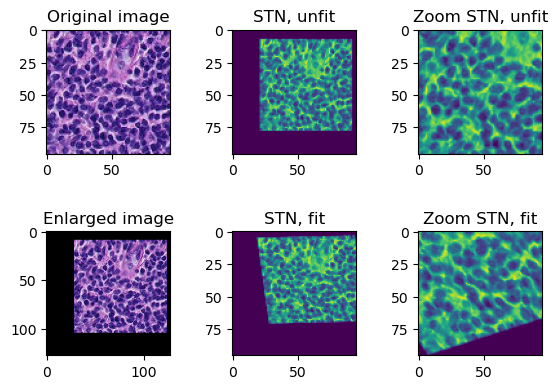

In [12]:
plot()

# stn_model.evaluate(val_ds_mod, val_ds)
# stn_model_zoom.evaluate(val_ds_mod, val_ds);